# Современные методы анализа данных (итоговый отчёт)
<font size="4"> Александр Попов, НИУ ВШЭ СПб - ИСВЧК </font>

Всем привет! Меня зовут Саша, и это мой notebook для проекта по "Современным Методам Анализа Данных"! 

**Целью** данного проекта является пополнение моей музыкальной коллекции новыми песнями. В последнее время я немного расстраиваюсь от рекомендаций стримингового сервиса Spotify, и поэтому решил взять иницативу в свои руки и попробовать **проанализировать свой музыкальный вкус**, чтобы выявить, какие жанры, особенности в песнях мне нравятся или не нравятся. 

В качестве непосредственно данных для этого проекта я использовал **Spotify API**, через который (и через обращение за своими персональными данными) взял **свою историю прослушиваний музыки в Спотифае**. Метод добычи данных и многие второстепенные итоги анализа описаны в недельных дневниках, на которые я буду ссылаться. Здесь же попробуем сконцентрироваться на достижении цели.

*{настоятельно рекомендую ознакамливаться с ноутбуков, подключив плагин collapsable headings - удобнее будет}*

In [1]:
# основной датасет для работы
import pandas as pd
ds = pd.read_csv('spotimy.csv').drop('Unnamed: 0', 1)

## Explonatory Data Analysis

Приступая к анализу истории прослушивания, я прежде всего связываю данные с собой как с косвенным объектом исследования. Потому хорошо было бы понять, как именно данные описывают мой музыкальный вкус, в частности - как работают `audio features`, функционал Спотифая, позволяющий "оценвиать" песни со всех сторон (в теории).

Давайте проведём **Explonatory Data Analysis**.

In [81]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [10]:
ds = ds.drop(columns = ["id", "type", "uri", "track_href", "analysis_url", "time_signature"])
ds.sort_values(by='plays', ascending=False).head(10)

,artistName,trackName,min,plays,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
6696,The xx,Crystalised,186.410583,82,0.762,0.484,11,-12.368,0,0.0311,0.812000,0.389000,0.0841,0.4150,122.916,201947
6872,Twenty One Pilots,Heavydirtysoul,198.206317,78,0.613,0.873,7,-6.376,0,0.0449,0.003970,0.001110,0.3670,0.3920,129.989,234813
4535,Muse,Undisclosed Desires,248.830100,77,0.683,0.585,8,-6.760,1,0.0323,0.008190,0.016200,0.0797,0.6410,115.997,235000
7632,toe,グッドバイ -album version-,355.505767,77,0.459,0.660,1,-9.603,0,0.0986,0.047700,0.037300,0.0674,0.0375,134.991,300373
5328,Radiohead,Creep,166.611917,75,0.515,0.430,7,-9.935,1,0.0372,0.009700,0.000133,0.1290,0.1040,91.844,238640
6547,The Rasmus,In the Shadows,242.475567,75,0.600,0.796,2,-4.481,1,0.0275,0.000109,0.000052,0.4840,0.7500,105.991,257920
4732,Noize MC,Вояджер-1,186.011867,74,0.630,0.729,2,-7.950,0,0.0600,0.132000,0.000000,0.3990,0.4810,125.004,214556
5640,Royal Blood,Out of the Black,252.562050,72,0.520,0.981,2,-2.750,1,0.0906,0.000867,0.001770,0.1970,0.6330,158.937,240572
5643,Royal Blood,Ten Tonne Skeleton,145.637500,70,0.488,0.879,7,-3.329,0,0.0393,0.000488,0.000001,0.1400,0.5570,86.986,187853
5384,Radiohead,Reckoner,271.958867,67,0.523,0.656,4,-7.441,0,0.0262,0.511000,0.160000,0.0679,0.2140,104.271,290213


#### Поговорим поподробнее про переменные о датасете:  

* `artistName` и `trackName` есть всем известные исполнитель и называние песни;
* `min` и `plays` показывают, сколько раз эта песня была воспроизведена с аккаунта (в минутах и разах);
* `duration_ms` - продолжительность песни, в милисекундах. 

Дальше идут те самые `audio_features` апишки Спотифая (подробнее о которых можно прочитать [тут](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features "тык :)")):

* `danceability` - мера уверенности, что под музыку можно танцевать? от 0 до 1 (1 - очень вероятно, что можно)
* `energy` - энергичность трека по шкале от 0 до 1 (у death core она будет высокая, у Баха - маленькая)
* `key` - тональность музыки по [высотным классам](https://ru.wikipedia.org/wiki/%D0%92%D1%8B%D1%81%D0%BE%D1%82%D0%BD%D1%8B%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81) (0 <=> C <=> До)
* `loudness` - средняя сила звука трека, в Дб (наиболее вероятно варьируется о -60 до 0)
* `mode` - модальность музыки (мажор - 1, минор - 0)
* `speechiness` - наличие слов по шкале от 0 до 1 (1 - токшоу, песни варьируется от 0.3 до 0.7)
* `acousticness` - мера вероятности акустичности трека по шкале от 0 до 1 (1 - очень вероятно, что акустичный)
* `instrumentalness` - вероятность отсутствия слов по шкале от 0 до 1 (1 - очень вероятно, что слов нет)
* `liveness`- вероятность живой записи по шкале от 0 до 1 (0.8 - очень вероятно, что запись живая)
* `valence` - мера позитивности трека по шкале от 0 до 1 (1 - очень вероятно, что позитивный)
* `tempo` - мера темпа музыки, ударов в минуту (обычно около ста)

Сами разработчики объединяют фичи по некоторым признакам: 

* *Mood/Настроение*: Danceability, Valence, Energy, Tempo
* *Properties/Свойства*: Loudness, Speechiness, Instrumentalness
* *Context/Контекст*: Liveness, Acousticness
* Segments, Tatums, Bars, Beats, Pitches, Timbre...

#### Визуализация данных


По ***граффику корреляции переменных*** видно:

* `min` и `plays` сильно коррелируют, но не на сто процентов - иногда песни скипаются. С остальными переменными уровень корреляции низкий, так что их вполне уместно обозвать целевыми;
* `energy` очень сильно коррелирует с `loudness` (энергичная музыка чаще всего громкая) и `acousticness` (акустически музыку сыграть громко сложновато, если не на органе бахать) и просто коррелирует с `instrumentalness` и `valence`.
* При этом, `danceability` с `energy` коррелируют не так сильно, хотя уровень взаимосвязи с `loudness` и `valence` у неё высокий.

В целом вывод следующий: так как сами разработчики метрик подразумевают какую-то их категоризацию, вряд ли имеет смысл строить модели по всему их набору. Этот вывод был подтверждён в дневниках ко 2ой и 4ой неделям проекта:

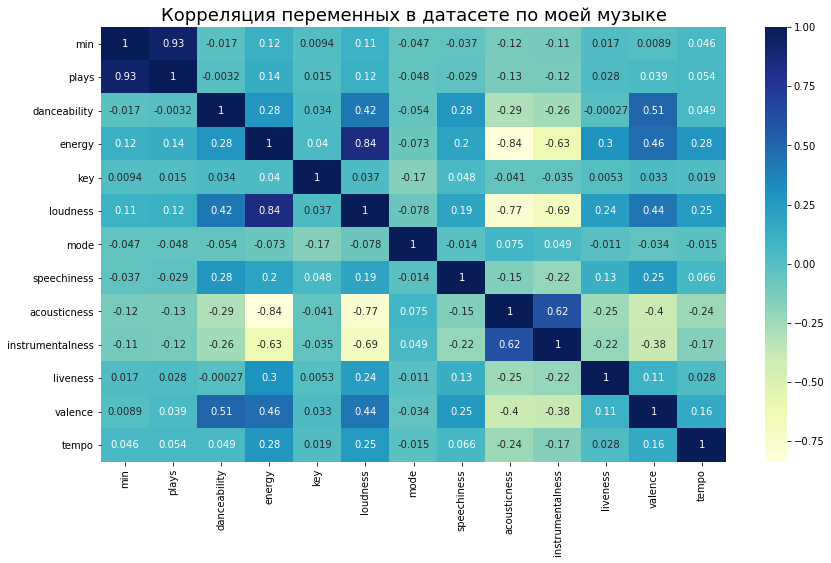

In [27]:
fig, ax = plt.subplots(figsize=(14,8)) 
ax.set_title('Корреляция переменных в датасете по моей музыке', fontsize=18)
sns.heatmap(ds.drop(columns = 'duration_ms').corr(), annot=True,  cmap="YlGnBu", ax=ax);

При отрисовке ***парных графиков `plays`-`audio_feature`*** мы можем посмотреть на распределение значений признаков по целевым переменным. Какая-либо форма тут прослеживается с трудом, что также аукнется при моделировании, но какие-то инсайты тоже можно выудить: 

* `instrumentalness` и `acousticness` стремятся принимать значения, близкие к целым;
* `loudness` и `speechiness` кучкуются в узких диапазонах с редкими выбросами.

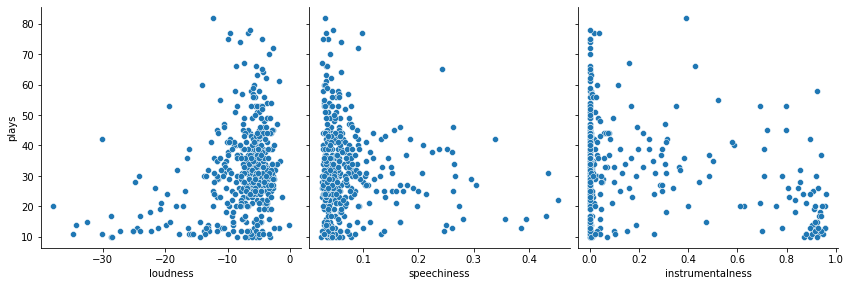

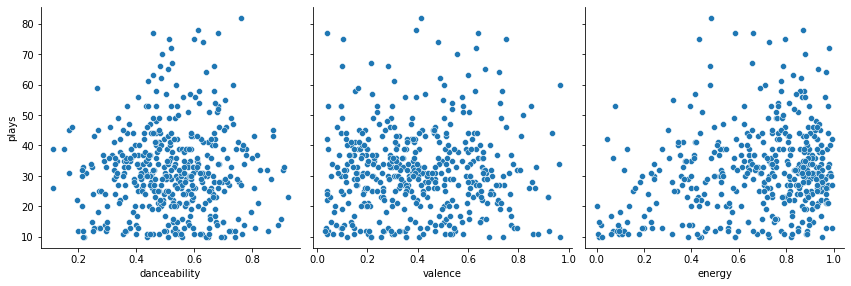

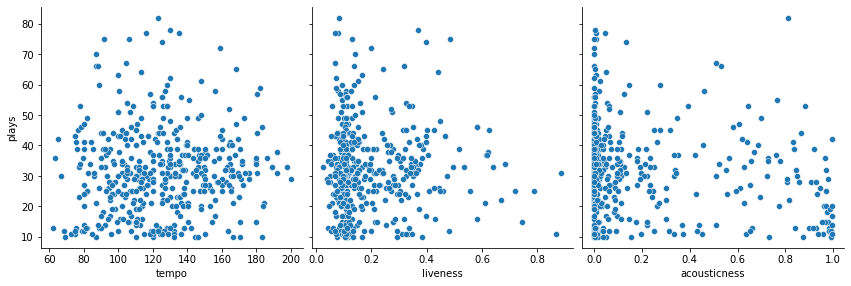

In [40]:
sns.pairplot(ds.loc[ds['plays'] >= 10], 
                    y_vars = 'plays',
                    x_vars = ["loudness", "speechiness", "instrumentalness"], height=4)
sns.pairplot(ds.loc[ds['plays'] >= 10], 
                    y_vars = 'plays',
                    x_vars = ["danceability", "valence", "energy"], height=4)
sns.pairplot(ds.loc[ds['plays'] >= 10], 
                    y_vars = 'plays',
                    x_vars = ["tempo", "liveness", "acousticness"], height=4)

plt.show();

Ну и просто визуализируем ***распределения наших показателей*** для всей выборки:

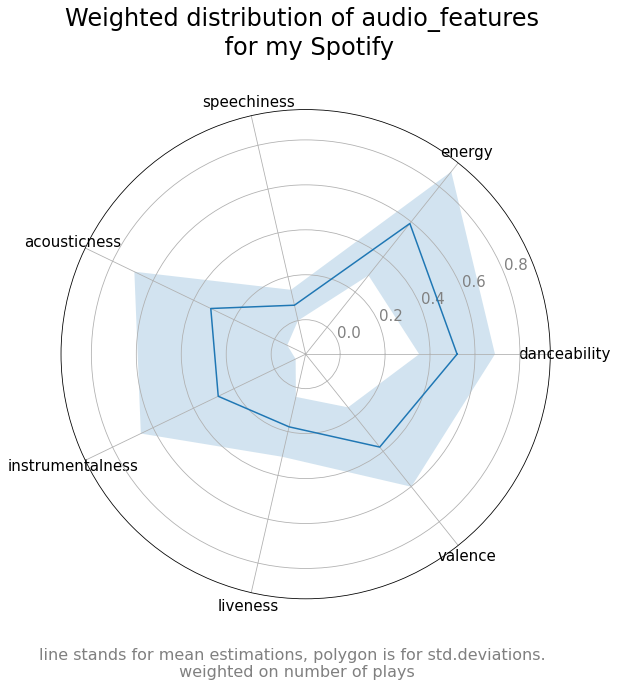

In [81]:
subset = ds.reindex(ds.index.repeat(ds.plays))
subset = subset.drop(columns = ['artistName', 'trackName', 'min', 'plays', 'key', 'mode', 'duration_ms', 'loudness', 'tempo'])

fig=plt.figure(figsize=(12,9));

categories=list(subset.columns)
N=len(categories)

value=list(subset.mean())
value+=value[:1]

value2=list(np.std(subset))
value2+=value2[:1]

angles=[n/float(N)*2*math.pi for n in range(N)]
angles+=angles[:1]

mini = list(np.array(value)-np.array(value2))
maxi = list(np.array(value)+np.array(value2))

plt.polar(angles, value);
plt.fill_between(angles, mini, maxi, alpha=0.20);

plt.title('Weighted distribution of audio_features \n for my Spotify', size=24, y = 1.1)
plt.suptitle('line stands for mean estimations, polygon is for std.deviations. \n weighted on number of plays', 
             size=16, color = 'grey', y = 0.05)

plt.xticks(angles[:-1],categories, size=15)
plt.yticks(color='grey',size=15)

plt.show()

#### Выводы

EDA показал, что музыка, которую я когда-либо слушал, достаточно разноплановая. Это видно по распределению и стандартным отклонениям многих переменных. Из этого следует первый страшный вывод:

**1. Построить качественную модель по всем наблюдениям в выборке не получится.**

Второй вывод следует из всё тех же распределений переменных (помним, что часть из них стремится к целым числам, а другая очень кучная) и таблицы корреляции, где сразу несколько переменных оказались тесно взаимосвязаны друг с другом:

**2. Построить качественную модель по всем переменным тоже вряд ли выйдет.**

***Что я хочу сделать?*** У меня появилась идея, опирающийся на моём *prior knowlledge* об объекте исследования, своём музыкальном вкусе: сет песен, которые я хочу послушать, зависит прежде всего от моего настроения, компании, времени года и опьянения. Так может, песни можно как-то кластеризовать по похожести между собой, чтобы выделить сеты песен, которые я могу слушать вместе, а предиктивные модели пилить уже по отдельности для каждой из групп?

Эту гипотезу я и планирую проверить.

## Кластеризация 

В качесте **сегментации** своих музыкальных пердпочтений, я попробую **кластеризовать песни по типам, которые бы образовали группы (возможно, плейлисты) под разные настроения / ситуации**. Например: для учёбы или работы я предпочитаю включать на фоне lofi hip-hop, во время уборки в квартире - энергичные поп-рок треки, а для чтения предпочитаю неоклассику. Чаще всего я кручу одни и те же плейлисты, но иногда открываю новые или пользуюсь рекомендациями - может, я забыл о каких-то песнях в каких-то контекстах?



####  Иерархическая кластеризация

Ни DBSCAN, ни K-means не дали нам хорошего итога по кластеризации *(см. днвники по 2ой неделе)*. Попробуем последний метод, рассказанный на этом курсе: ***иерархическая кластеризация***. Для этого сначала почистим данные, оставив только те песни, которые были прослушаны <u>хотя бы 3 раза</u>.

In [71]:
ds = ds[ds['plays']>=3]
clus = ds[["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]]

In [72]:
from sklearn.cluster import AgglomerativeClustering # ‘ward’, ‘complete’, ‘average’, ‘single’

inertia = []
for method in ['ward', 'complete', 'average']:
    print("by", method, "method:")
    for i in range(1,6):
        amodel = AgglomerativeClustering(linkage = method, n_clusters = i)
        amodel = amodel.fit_predict(clus)
        unique, counts = np.unique(amodel, return_counts=True)
        print(unique, counts)

by ward method:
[0] [1642]
[0 1] [1152  490]
[0 1 2] [817 490 335]
[0 1 2 3] [335 490 661 156]
[0 1 2 3 4] [661 490 224 156 111]
by complete method:
[0] [1642]
[0 1] [926 716]
[0 1 2] [716 693 233]
[0 1 2 3] [560 693 233 156]
[0 1 2 3 4] [693 156 233 416 144]
by average method:
[0] [1642]
[0 1] [770 872]
[0 1 2] [553 872 217]
[0 1 2 3] [872 551 217   2]
[0 1 2 3 4] [150 722 217   2 551]


Все три метода неплохо справились на `n_clusters = 3`. Проверим итоги на данных:

In [73]:
for method in ['ward', 'complete', 'average']:
    amodel = AgglomerativeClustering(linkage = method, n_clusters = 3)
    amodel = amodel.fit_predict(clus)
    ds[str(method)] = amodel

<ipython-input-73-24d3e8fea4c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds[str(method)] = amodel
<ipython-input-73-24d3e8fea4c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds[str(method)] = amodel
<ipython-input-73-24d3e8fea4c7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [74]:
ds.sort_values(by = "plays", ascending = False)[['artistName','trackName',
                                                  'ward', 'complete', 'average']].groupby('ward').head(7).sort_values(by = "ward")


,artistName,trackName,ward,complete,average
6872,Twenty One Pilots,Heavydirtysoul,0,1,1
4535,Muse,Undisclosed Desires,0,1,1
7632,toe,グッドバイ -album version-,0,1,1
5328,Radiohead,Creep,0,1,1
6547,The Rasmus,In the Shadows,0,1,1
4732,Noize MC,Вояджер-1,0,1,1
5640,Royal Blood,Out of the Black,0,1,1
4185,Mazzy Star,Look On Down From The Bridge,1,0,0
5374,Radiohead,Motion Picture Soundtrack,1,0,0
5376,Radiohead,Nude,1,0,0


Все три метода одинаково выделяют два кластера. С точки зрения экспертной оценки, `ward == 0` вошли более агрессивные (рокерские?) песни, а в `ward == 1` - более медленные, спокойные. В третьем кластере методы алгоритма соглашались меньше: лично мне больше всего понравилась версия `average`, потому что песня **DEUTSCHLAND**, по моему мнению, хорошо относится **к первому кластеру**, а **One More Love Song - ко второму**. Её я и выберу для дальнейшей работы.

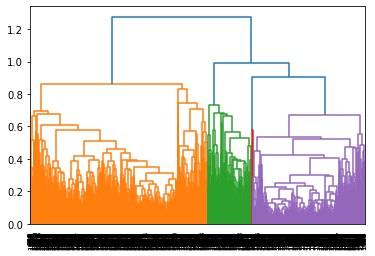

In [82]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

mergings = linkage(clus, method='average')
dendrogram(mergings,
           leaf_rotation=90,
           leaf_font_size=7,
           )

plt.show()

In [255]:
ds = ds.drop(columns = ['ward', 'complete'])
ds.sort_values(by = "min", ascending = False).head(10)

KeyError: "['ward' 'complete'] not found in axis"

## Предсказательные модели

Машинное обучение - великая вещь, которой можно сделать кучу всяких интересностей. К сожалению, мы будем не менять мир будущего смелыми ходами, а всего лишь строить предсказательную модель нашего музыкального вкуса. Для этого создадим новую переменную `agg_plays` - отношение проигранных минут к длине трека. Из всех трёх **задач регрессии** *(см. дневники 4ой недели)* эта выглядит наиболее релевантно: теперь значения не зависят от секундных скипов, а полное прослушивание трека будет иметь больший вес.

In [172]:
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn import tree, ensemble, metrics
import math

ds['agg_plays'] = round(ds['min']/(ds['duration_ms']/1000/60), 4)

agg_plays1 = ds[ds['average'] == 0]['agg_plays']
agg_plays2 = ds[ds['average'] == 1]['agg_plays']
agg_plays3 = ds[ds['average'] == 2]['agg_plays']

feat1 = ds[ds['average'] == 0][["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]]
feat2 = ds[ds['average'] == 1][["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]]
feat3 = ds[ds['average'] == 2][["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"]]

### Модели

Для наибольшей валидности эксперимента, я взял пять разных моделей, построил предсказания и отобразил графики сходства предсказанных и реальных значений на тестовых выборках. Для ансамблей также применялась кросс-валидацию, чтобы постараться избежать переобучения. В этом разделе описан процесс моделирования: если он вам сейчас не интересен, переходите к разделу *'Сравнение и выводы'*.

#### Регрессия

R_sq модели составил 0.0599 для 1-го кластера


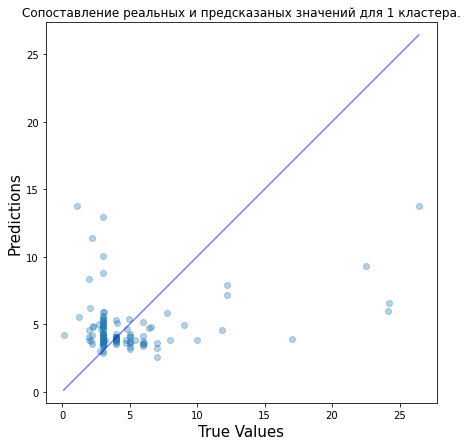

R_sq модели составил 0.0094 для 2-го кластера


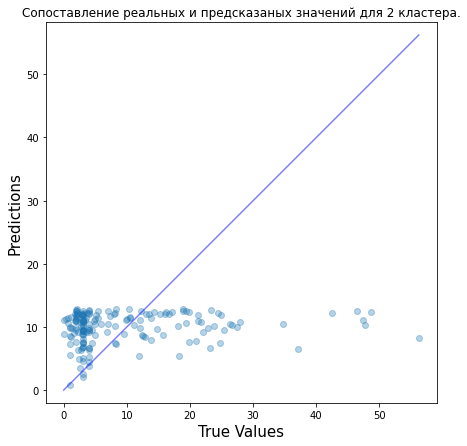

R_sq модели составил -0.1459 для 3-го кластера


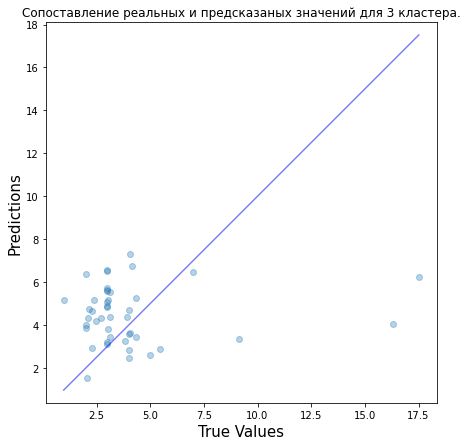

In [159]:
from sklearn.linear_model import LinearRegression #r2reg

i=1
r2reg = []
for cluster in [[agg_plays1, feat1], [agg_plays2, feat2], [agg_plays3, feat3]]:
    y = cluster[0]
    x = cluster[1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/5, random_state = 0)
    reg = LinearRegression()
    reg.fit(x_train,y_train)
    r2 = round(reg.score(x_test, y_test),4)
    print("R_sq модели составил {} для {}-го кластера".format(r2, str(i)))
    
    r2reg.append(r2)
    
    plt.figure(figsize=(7,7))
    plt.scatter(y_test, reg.predict(x_test), alpha = 0.33)

    p1 = max(max(reg.predict(x_test)), max(y_test))
    p2 = min(min(reg.predict(x_test)), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-', alpha = 0.5)
    plt.title('Сопоставление реальных и предсказаных значений для {} кластера.'.format(str(i)))
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()
    
    i+=1

#### Дерево

R_sq модели составил -1.0677 для 1-го кластера


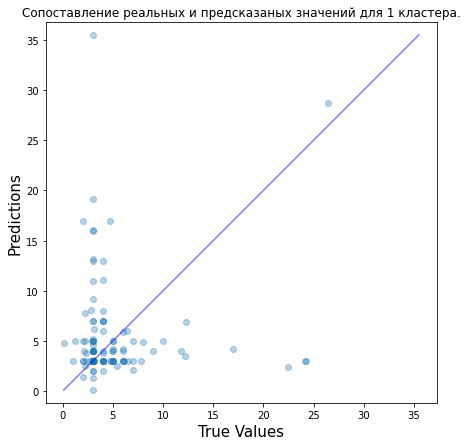

R_sq модели составил -0.789 для 2-го кластера


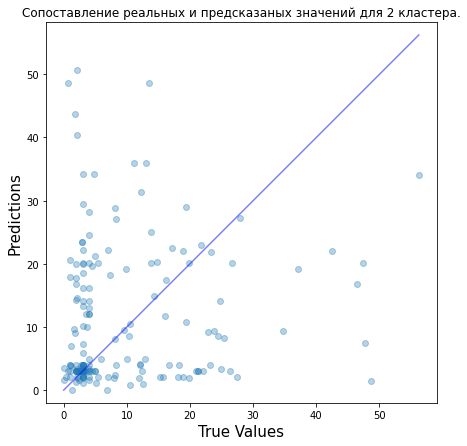

R_sq модели составил -2.9916 для 3-го кластера


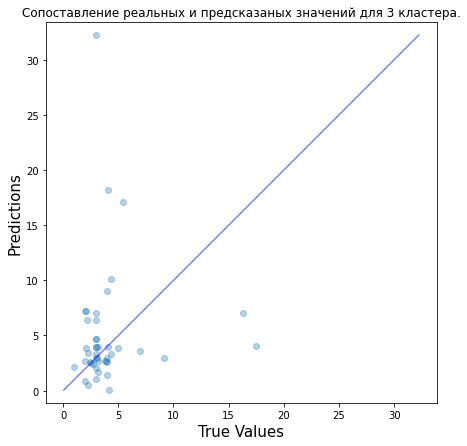

In [161]:
from sklearn import tree #r2tree

i=1
r2tree = []
for cluster in [[agg_plays1, feat1], [agg_plays2, feat2], [agg_plays3, feat3]]:
    y = cluster[0]
    x = cluster[1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/5, random_state = 0)
    treee = tree.DecisionTreeRegressor()
    treee.fit(x_train,y_train)
    r2 = round(treee.score(x_test, y_test),4)
    print("R_sq модели составил {} для {}-го кластера".format(r2, str(i)))
    
    r2tree.append(r2)
    
    plt.figure(figsize=(7,7))
    plt.scatter(y_test, treee.predict(x_test), alpha = 0.33)

    p1 = max(max(treee.predict(x_test)), max(y_test))
    p2 = min(min(treee.predict(x_test)), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-', alpha = 0.5)
    plt.title('Сопоставление реальных и предсказаных значений для {} кластера.'.format(str(i)))
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()
    
    i+=1

#### Random Forest

R_sq модели составил -0.2086 для 1-го кластера


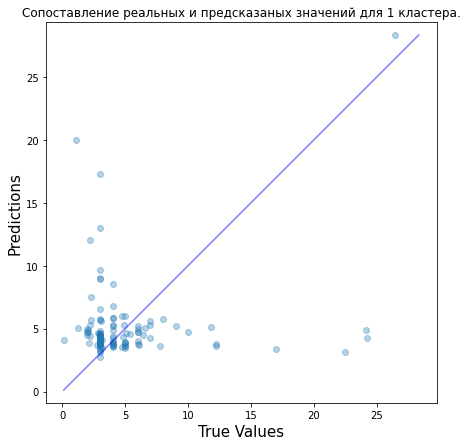

R_sq модели составил -0.0891 для 2-го кластера


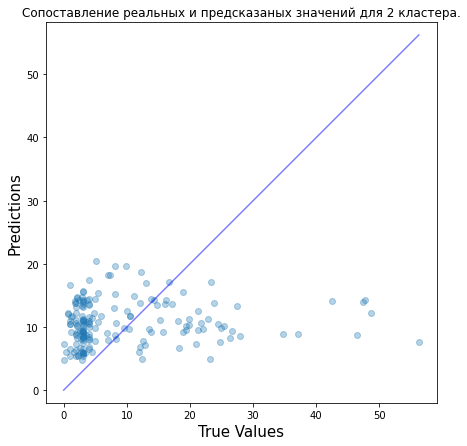

R_sq модели составил -1.1832 для 3-го кластера


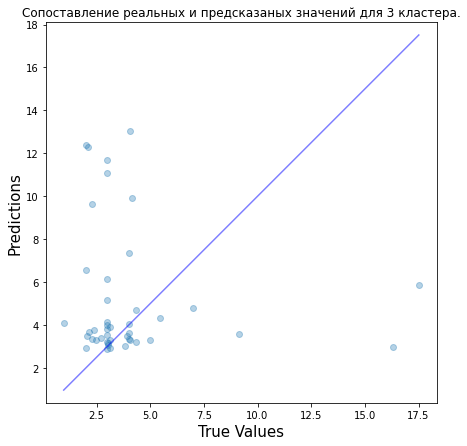

In [174]:
from sklearn.ensemble import RandomForestRegressor #r2rf

i=1
r2rf = []
for cluster in [[agg_plays1, feat1], [agg_plays2, feat2], [agg_plays3, feat3]]:
    y = cluster[0]
    x = cluster[1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/5, random_state = 0)
    rf = RandomForestRegressor()
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    r2 = round(np.mean(cross_val_score(rf, x, y, scoring='r2', cv=cv, error_score='raise')),4)
    print("R_sq модели составил {} для {}-го кластера".format(r2, str(i)))
    
    r2rf.append(r2)
    
    rf.fit(x_train, y_train)
    
    plt.figure(figsize=(7,7))
    plt.scatter(y_test, rf.predict(x_test), alpha = 0.33)

    p1 = max(max(rf.predict(x_test)), max(y_test))
    p2 = min(min(rf.predict(x_test)), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-', alpha = 0.5)
    plt.title('Сопоставление реальных и предсказаных значений для {} кластера.'.format(str(i)))
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()
    
    i+=1

#### Градиентный Бустинг

R_sq модели составил -0.2451 для 1-го кластера


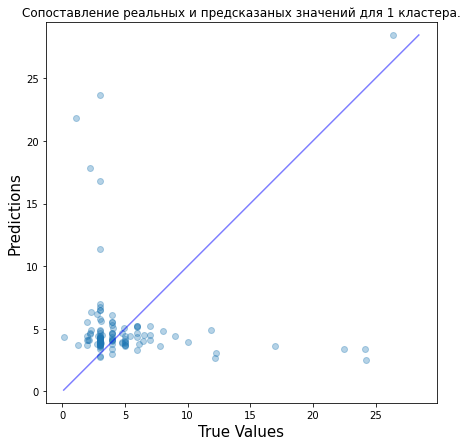

R_sq модели составил -0.0784 для 2-го кластера


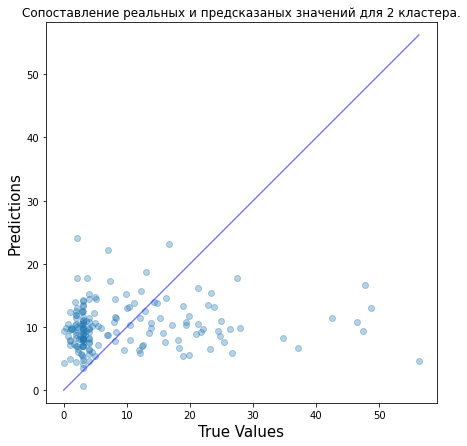

R_sq модели составил -1.3826 для 3-го кластера


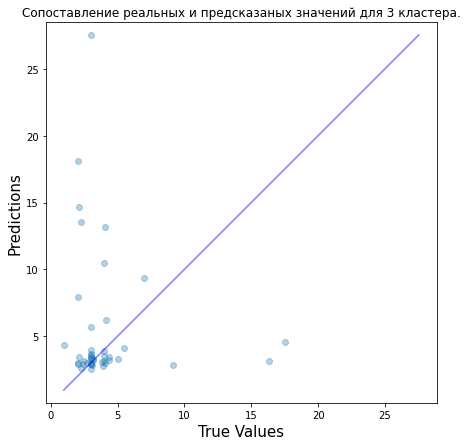

In [175]:
from sklearn.ensemble import GradientBoostingRegressor #r2boost

i=1
r2boost = []
for cluster in [[agg_plays1, feat1], [agg_plays2, feat2], [agg_plays3, feat3]]:
    y = cluster[0]
    x = cluster[1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/5, random_state = 0)
    boost = GradientBoostingRegressor()
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    r2 = round(np.mean(cross_val_score(boost, x, y, scoring='r2', cv=cv, error_score='raise')),4)
    print("R_sq модели составил {} для {}-го кластера".format(r2, str(i)))
    
    r2boost.append(r2)
    
    boost.fit(x_train, y_train)

    
    plt.figure(figsize=(7,7))
    plt.scatter(y_test, boost.predict(x_test), alpha = 0.33)

    p1 = max(max(boost.predict(x_test)), max(y_test))
    p2 = min(min(boost.predict(x_test)), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-', alpha = 0.5)
    plt.title('Сопоставление реальных и предсказаных значений для {} кластера.'.format(str(i)))
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()
    
    i+=1

#### XGBoost

R_sq модели составил -0.4259 для 1-го кластера


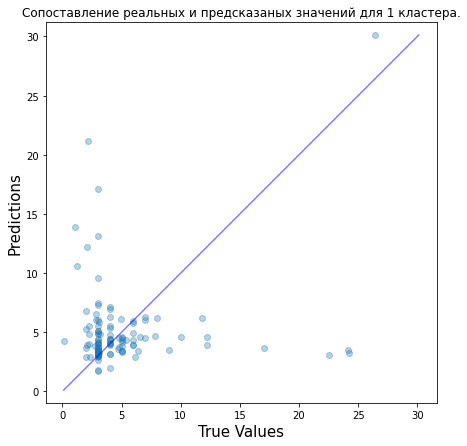

R_sq модели составил -0.2548 для 2-го кластера


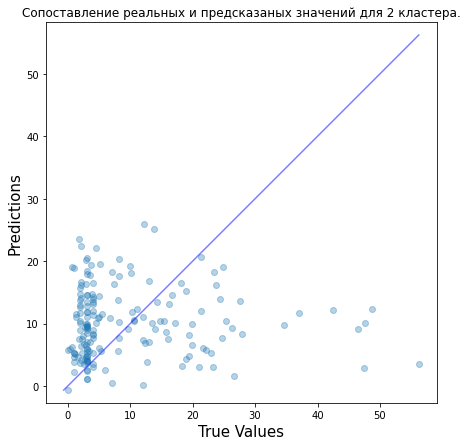

R_sq модели составил -1.2936 для 3-го кластера


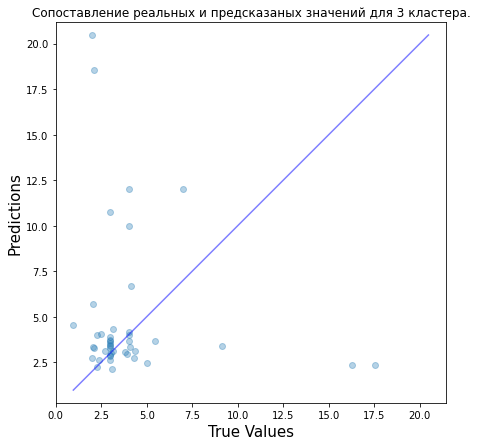

In [176]:
from xgboost import XGBRegressor #r2xgb

i=1
r2xgb = []
for cluster in [[agg_plays1, feat1], [agg_plays2, feat2], [agg_plays3, feat3]]:
    y = cluster[0]
    x = cluster[1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/5, random_state = 0)
    xgb = XGBRegressor()
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    r2 = round(np.mean(cross_val_score(xgb, x, y, scoring='r2', cv=cv, error_score='raise')),4)
    print("R_sq модели составил {} для {}-го кластера".format(r2, str(i)))
    
    r2xgb.append(r2)
    
    xgb.fit(x_train,y_train)

    
    plt.figure(figsize=(7,7))
    plt.scatter(y_test, xgb.predict(x_test), alpha = 0.33)

    p1 = max(max(xgb.predict(x_test)), max(y_test))
    p2 = min(min(xgb.predict(x_test)), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-', alpha = 0.5)
    plt.title('Сопоставление реальных и предсказаных значений для {} кластера.'.format(str(i)))
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()
    
    i+=1

### Сравнение и выводы

Как и в *дневнике к 4ой неделе*, точность предсказаний всеми моделями оставляет желать лучшего. Удивительно, но для предсказаний во всех трёх кластерах **лучшей точностью обладает обычная линейная регрессия** - более того, это **единственная модель, достигшая положительных значений по R_squared** (они всё ещё малы, но уже хотя бы не отрицательны)!

In [177]:
results = {'Regression': r2reg, 'DecisionTree': r2tree, 'RandomForest': r2rf, 'GradBoosting': r2boost, 'XGBoost': r2xgb,}
results = pd.DataFrame(data=results)
results.head()

,Regression,DecisionTree,RandomForest,GradBoosting,XGBoost
0,0.0599,-1.0677,-0.2086,-0.2451,-0.4259
1,0.0094,-0.7890,-0.0891,-0.0784,-0.2548
2,-0.1459,-2.9916,-1.1832,-1.3826,-1.2936


Бустинг и бэггинг были близки к подобному результату на втором кластере, но во всех остальных случаях перфоманс моделей слишком сильно отличался от регрессии, причём как по точности, так и по времени компиляции. Видимо, придётся не выёживаться и предсказывать всё регрессией: доведём её до ума, применив кросс-валидацию и затьюнив гиперпараметры.

R_squred для 1го кластера: 0.0633
RMSE для 1го кластера: 4.3828


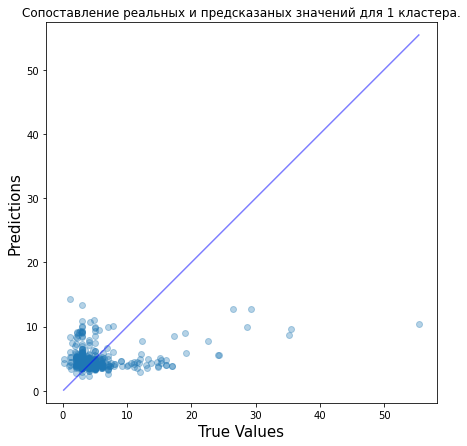

R_squred для 2го кластера: 0.0271
RMSE для 2го кластера: 10.6002


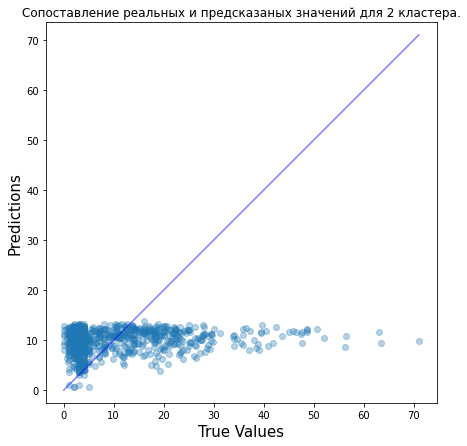

R_squred для 3го кластера: -0.0257
RMSE для 3го кластера: 4.8038


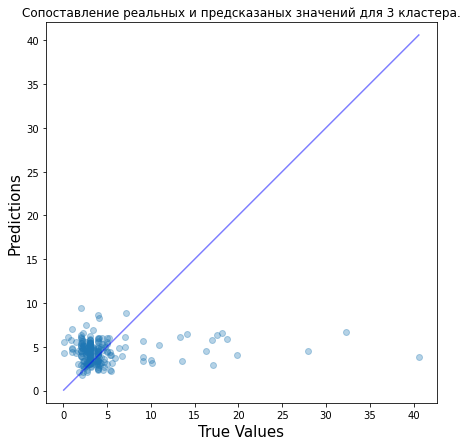

In [219]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

i=1
for cluster in [[agg_plays1, feat1], [agg_plays2, feat2], [agg_plays3, feat3]]:

    reg = LinearRegression()
    y = np.array(cluster[0])
    x = np.array(cluster[1])
    reg_pred = cross_val_predict(reg, x, y, cv=10, method='predict')
    
    print("R_squred для {}го кластера: {}".format(str(i), round(metrics.r2_score(y, reg_pred),4)))
    print("RMSE для {}го кластера: {}".format(str(i), round(np.sqrt(metrics.mean_squared_error(y, reg_pred)),4)))

    plt.figure(figsize=(7,7))
    plt.scatter(y, reg_pred, alpha = 0.33)

    p1 = max(max(reg_pred), max(y))
    p2 = min(min(reg_pred), min(y))
    plt.plot([p1, p2], [p1, p2], 'b-', alpha = 0.5)
    plt.title('Сопоставление реальных и предсказаных значений для {} кластера.'.format(str(i)))
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()
    
    i+=1

Кросс-валидация немного подняла точность, но в целом она всё равно слабо отличается от обычного "просто сравним со средним". У моделей не такие большие метрики ошибки, что означает в целом неплохой фит модели под данные. Просто, видимо, сами данные в таком виде плохо поддаются предсказанию (по крайней мере на уровне кластеризованных ансамблей с кросс-валидацией). Основные гипотезы, почему всё так плохо:
* высокая однородность данных: картины распределений переменных показывают, что на шкале от 0 до 1 треки слабо отличаются друг от друга.
* переобучение ансамблей из-за маленького объёма данных.

### Интерпретация модели

Полученная итоговая модель достаточно удобна в плане объянения, как результаты получались: нам достаточно просто посмотреть на результирующие регресси по каждому из кластеров. В этом плане нам относительно повезло, и запариваться с iml не придётся (хотя лучше бы запарились, но да ладно).

In [231]:
import statsmodels.api as sm

i = 1
for cluster in [[agg_plays1, feat1], [agg_plays2, feat2], [agg_plays3, feat3]]:
    y = np.array(cluster[0])
    x = cluster[1]
    x0 = sm.add_constant(x)
    smm = sm.OLS(y, x0)
    res = smm.fit()
    print('\033[1m OLS Регрессия для {}го кластера: \033[0m'.format(i))
    print(res.summary())
    print('\n \n \n')
    i += 1

 OLS Регрессия для 1го кластера: 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     11.32
Date:                Sat, 25 Dec 2021   Prob (F-statistic):           1.96e-13
Time:                        01:07:27   Log-Likelihood:                -1582.4
No. Observations:                 553   AIC:                             3181.
Df Residuals:                     545   BIC:                             3215.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const 

Выводы по финальной модели:

* только переменная `instrumentalness` показала значимые результаты для всех трёх кластеров хотя бы на 90%-ом уровне значимости. Напоминание: она не про инструментальность или мелодичность слов, а про отсутствие слов. Так как среди музыки я в основном слушаю именно песни, почти везде этот параметр стремится к нулю. Большинство тех треков, у которых шанс встречи слов меньше, попали в последний кластер (см. коэфы).
* во втором кластере (который был связан с более энергичными и бодрыми песнями, он же нулевой по методу `ward`) также значимыми оказались `energy` и `speechiness`, причём все - на 99% уровне значимости. Так, рост `energy` песни на 0.1 увеличивает потцениальное число полных прослушиваний (`agg_plays`) на 0.8, в то время как аналогичный рост `speechiness` уменьшит этот показатель аж на 1.3. Это вяжется с общим представлением о музыке в данном кластере: энергичные песни преимущественно без речетатива, но со словами.
* параметр `valence`, на который лично я возлагал большие надежды, показал себя не лучшим образом. Мои друзья часто подчёркивают, что моя музыка слишком грустная и меланхоличная, но даже кластер с достаточно милыми и грустными песнями (1ый) показал незначимость этого показателя. Тут я позволю себе грешить на разработчиков Spotify и неидеальность соотношения количественной оценки настроения трека с его эмоциональным восприятем пользователем.

## Итоги

*Вот и всё… Неплохая получилась история. Интересная, весёлая, порой немного грустная, а главное – поучительная… (c).*

На самом деле, я очень рад, что мне получилоь поработать с настолько легкоинтерпретируемыми данными (ведь эти данные генерировал я сам). Цель проекта выполнилась далеко не лучшим образом, однако, позитивных моментов всё же больше: 

* мне удалось самому сгенерировать гипотезу о разности перфоманса моделей в зависимости от условного "кластера" песен. Резделение на "музыку для вождения", "биты для учёбы" и "шоб навзрыд" мне казалось достаточно практичным, чтобы работать с ним. Итоги, вроде бы, получились даже лучше, чем модели для всех данных (основываясь на *дневниках 4ой недели*), но всё ещё недостаточно крутыми.
* во многом это может связано с неидеальностью метрик `SpotifyAPI`. Технические вещи (такие как ритм, тональность, громкость, то есть те, которые изначально можно измерить количественно) система захватывает отлично. Однако, когда дело доходит до каких-то более абстрактных понятий (танцевальность, настроение и т.д.), разработчики предпочитают ограничиываться вероятностными оценками, которые во многом тоже не идеальны (или не приняты мною).
* как можно было бы добиться лучших итогов? Импортировать данные о плейлистах, любимых песнях, включить в анализ время воспроизведения трека и превратить это в панельные данные, исследуя не только качества песен, но и, например, совстречаемость в сессии, или безприрывность проигрывания. Идей много, знаний мало.

Спасибо, что поддерживали меня и рассказывали интересности. Буду рад вообще всем комментариям, потому что это важно для меня будущего датасаентиста Александра. В качестве бонуса - одна из моих любимых песен, чтобы вы тоже могли погрузиться в мир `audio_features`, ну и покритиковать их немного.

С наступающим!

In [253]:
ds[ds['trackName'] == 'Reckoner'].drop(columns = ["plays", "duration_ms", "average"]) # ну какой valence 0.2?!

,artistName,trackName,min,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,agg_plays
5384,Radiohead,Reckoner,271.958867,0.523,0.656,4,-7.441,0,0.0262,0.511,0.16,0.0679,0.214,104.271,56.2261


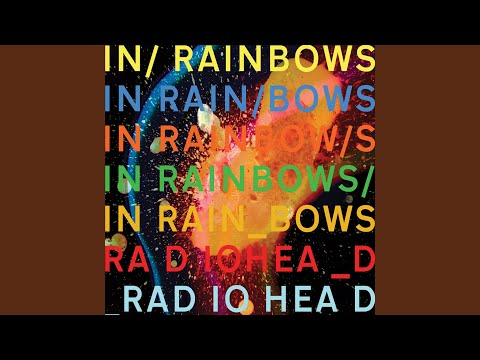

In [237]:
from IPython.display import YouTubeVideo
YouTubeVideo('pYHEpDnvVPk', width=900, height=450)